Building the following trading simulation.

You can trade three stocks: Apple, Coca-Cola, and IBM.

Your portfolio is rebalanced every week and held for a week.

At the beginning of each week, you make a decision to adjust your portfolio holding based on the following state variables: last week's return on these 3 stocks and your current holding on these three stocks.

Your simulation (episode) starts in the beginning of 2010 with an initial cash holding of 100

Your simulation (episode) terminates if the following conditions are met: your current cash holding + your current portfolio value <= 0 dollar. OR you have reached the end of the year 2017.

Your actions are to long 1 share, short 1 share, stay neutral for each stock -- your actions are three dimensional vectors.

At the end of each period, determine whether your simulation has ended by checking the date and the sum of your cash holding and portfolio value. The portofolio value is the sum of the value of the three stocks in your portfolio based on how many shares you hold.

When you commit an action, the immediate reward is the gain of the shares sold (shorted) minus the cost of the number of shares bought. We ignore the transaction cost here. When you reach the end, you receive an additional reward that is equal to the value of your portfolio at the end.

First build this experiment, and then plot the trajectory of your networth: cash+portfolio value over time under a random policy (randomly choosing actions at each state). Use a random state of 123. Assume no discounting. Use the data from Yahoo Finance.

In [15]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [16]:
# Set random seed 123
np.random.seed(123)

# Download stock data
def get_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    return data['Close']

# Define simulation parameters
start_date = '2010-01-01'
end_date = '2017-12-31'
initial_cash = 100
stocks = ['AAPL', 'KO', 'IBM']

# Download stock data
stock_data = pd.DataFrame({stock: get_stock_data(stock, start_date, end_date) for stock in stocks})

# Make index timezone-naive
stock_data.index = stock_data.index.tz_localize(None)

# Calculate weekly returns
weekly_returns = stock_data.resample('W-MON').last().pct_change().fillna(0)

def simulate_trading(initial_cash, weekly_returns, stock_data):
    cash = initial_cash
    portfolio = {stock: 0 for stock in stocks}
    net_worth_history = []
    portfolio_history = []
    cash_history = []
    portfolio_value_history = []

    for date, returns in weekly_returns.iterrows():
        # Find the closest date in stock_data
        closest_date_index = stock_data.index.get_indexer([date], method='nearest')[0]
        closest_date = stock_data.index[closest_date_index]
        
        actions = np.random.choice([-1, 0, 1], size=len(stocks))
        
        # First, sell stocks
        for i, stock in enumerate(stocks):
            if actions[i] == -1:  # Sell
                portfolio[stock] -= 1
                cash += stock_data.loc[closest_date, stock]
        
        # Then, buy stocks with the updated cash
        for i, stock in enumerate(stocks):
            if actions[i] == 1:  # Buy
                if cash >= stock_data.loc[closest_date, stock]:
                    portfolio[stock] += 1
                    cash -= stock_data.loc[closest_date, stock]
        
        # Calculate portfolio value
        portfolio_value = sum(portfolio[stock] * stock_data.loc[closest_date, stock] for stock in stocks)
        net_worth = cash + portfolio_value
        
        net_worth_history.append((date, net_worth))
        portfolio_history.append((date, portfolio.copy()))  # Store a copy of the portfolio for each date
        cash_history.append(cash)  # Store cash history
        portfolio_value_history.append(portfolio_value)  # Store portfolio value history
        
        # Check termination conditions
        if net_worth <= 0 or date >= pd.Timestamp('2017-12-31'):
            break
    
    return net_worth_history, portfolio_history, cash_history, portfolio_value_history


def plot_simulation(initial_cash, weekly_returns, stock_data):
    net_worth_history, portfolio_history, cash_history, portfolio_value_history = simulate_trading(initial_cash, weekly_returns, stock_data)

    dates, net_worths = zip(*net_worth_history)
    fig, axs = plt.subplots(3, 1, figsize=(13, 10))

    # First row: Plot the stock prices over time
    for i, stock in enumerate(stocks):
        initial_price = stock_data[stock].iloc[0]  # Get the initial price of the stock
        normalized_prices = stock_data[stock] / initial_price  # Normalize the prices
        axs[0].plot(stock_data.index, normalized_prices, label=stock)
    axs[0].set_title('Normalized Stock Prices Over Time')
    axs[0].set_ylabel('Normalized Price (Initial = 1)')
    axs[0].legend()
    axs[0].grid(True)

    # Second row: Plot the portfolio positions over time (every ~6 months)
    positions_dates = np.linspace(0, len(portfolio_history)-1, 15, dtype=int)  # Select 15 positions evenly spaced
    bar_width = 0.2  # Adjust this value to control the width of the bars
    x_positions = np.arange(len(positions_dates))

    for i, stock in enumerate(stocks):
        positions = [portfolio[1][stock] for i, portfolio in enumerate(portfolio_history) if i in positions_dates]
        axs[1].bar(x_positions + i * bar_width, positions, bar_width, label=stock)  # Offset the x positions for each stock
    axs[1].set_xticks(x_positions + bar_width)  # Adjust for center positioning
    axs[1].set_xticklabels([portfolio_history[i][0].strftime('%Y-%m-%d') for i in positions_dates], rotation=45)
    axs[1].set_title('Portfolio Positions Over Time')
    axs[1].set_ylabel('Number of Shares')
    axs[1].set_xlabel('Date')
    axs[1].grid(True)
    axs[1].legend()

    # Third row: Plot the net worth, cash, and portfolio value over time
    cash_values = cash_history  # Cash values over time
    portfolio_values = portfolio_value_history  # Portfolio values over time

    ax2 = axs[2].twinx()

    axs[2].plot(dates, cash_values, label='Cash', color='green', linestyle='--')
    axs[2].plot(dates, portfolio_values, label='Portfolio Value', color='orange', linestyle='-.')
    axs[2].set_ylabel('Cash & Portfolio Value ($)')
    axs[2].set_xlabel('Date')
    axs[2].grid(True)


    ax2.plot(dates, net_worths, label='Net Worth', color='blue')
    ax2.set_ylabel('Net Worth ($)')
    axs[2].legend(loc='upper left')
    ax2.legend(loc='upper right')
    axs[2].set_title('Cash, Portfolio Value, and Net Worth Over Time')

    plt.tight_layout()
    plt.show()

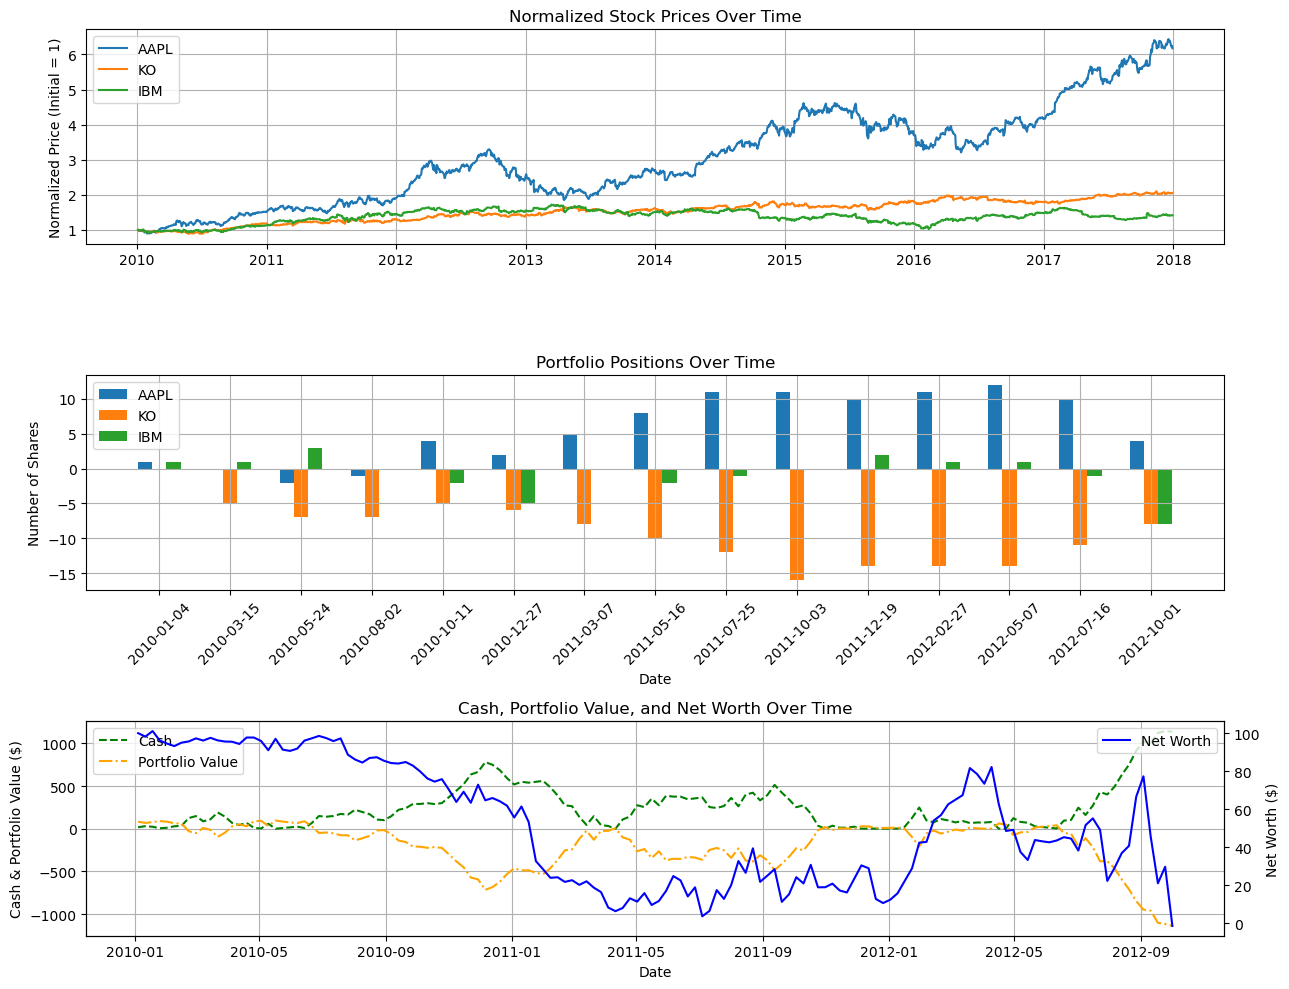

In [17]:
plot_simulation(initial_cash, weekly_returns, stock_data)

Implement a Q-learning algorithm. Start with a random policy and update the policy every 2 weeks. Tune the hyperparameters of the model you choose to estimate Q -- the objective is to maximize the total discounted reward. Do not use any data in 2018 (using any data in 2018 in this stage would disqualify this assignment). Report the total reward and also report the cash holding and portfolio value separately.

In [49]:
np.random.seed(123)

class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.90, epsilon=0.15):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', 
                                  learning_rate_init=learning_rate, max_iter=1000, random_state=123)
        self.model.fit(np.zeros((1, state_size)), np.zeros((1, action_size * 3)))
        
        self.scaler = StandardScaler()
        
    def get_action(self, state, epsilon_greedy):
        if np.random.rand() < epsilon_greedy:
            return np.random.choice([-1, 0, 1], size=self.action_size)
        q_values = self.model.predict(state.reshape(1, -1)).reshape(self.action_size, 3)
        return np.argmax(q_values, axis=1) - 1
    
    def train(self, state, action, reward, next_state, done):
        target = reward + (1 - done) * self.gamma * np.max(self.model.predict(next_state.reshape(1, -1)))
        target_f = self.model.predict(state.reshape(1, -1))
        for i in range(self.action_size):
            target_f[0][i*3 + (action[i] + 1)] = target
        self.model.partial_fit(state.reshape(1, -1), target_f)

def q_learning_simulation(initial_cash, weekly_returns, stock_data, episodes=500, epsilon_decay=0.99):
    state_size = len(stocks) * 2  # Last week's returns + current holdings
    action_size = len(stocks)
    agent = QLearningAgent(state_size, action_size)
    
    best_reward = -np.inf
    best_episode = None
    epsilon_greedy = 0.1
    
    for episode in range(episodes):
        cash = initial_cash
        portfolio = {stock: 0 for stock in stocks}
        total_reward = 0
        
        state = np.zeros(state_size)
        
        for week, (date, returns) in enumerate(weekly_returns.iterrows()):
            closest_date_index = stock_data.index.get_indexer([date], method='nearest')[0]
            closest_date = stock_data.index[closest_date_index]
            
            # Update state
            state[:len(stocks)] = returns
            state[len(stocks):] = [portfolio[stock] for stock in stocks]
            state = agent.scaler.fit_transform(state.reshape(1, -1)).flatten()
            
            # Get action, only update every 2 weeks
            if week % 2 == 0:
                action = agent.get_action(state, epsilon_greedy)
            
            # Execute action and get reward
            # First, sell stocks
            for i, stock in enumerate(stocks):
                if action[i] == -1:  # Sell
                    portfolio[stock] -= 1
                    cash += stock_data.loc[closest_date, stock]
            
            # Then, buy stocks with the updated cash
            for i, stock in enumerate(stocks):
                if action[i] == 1:  # Buy
                    if cash >= stock_data.loc[closest_date, stock]:  # No loan allowed
                        portfolio[stock] += 1
                        cash -= stock_data.loc[closest_date, stock]
            
            # Calculate new state and reward
            next_state = np.zeros(state_size)
            next_state[:len(stocks)] = returns
            next_state[len(stocks):] = [portfolio[stock] for stock in stocks]
            next_state = agent.scaler.transform(next_state.reshape(1, -1)).flatten()
            
            portfolio_value = sum(portfolio[stock] * stock_data.loc[closest_date, stock] for stock in stocks)
            reward = cash + portfolio_value - initial_cash
            total_reward += reward
            
            # Check termination conditions
            done = (cash + portfolio_value <= 0) or (date >= pd.Timestamp('2017-12-31'))
            
            # Train agent
            agent.train(state, action, reward, next_state, done)
            
            state = next_state
            
            if done:
                break
        
        # Epsilon decay for exploration-exploitation tradeoff
        epsilon_greedy *= epsilon_decay
        
        if total_reward > best_reward:
            best_reward = total_reward
            best_episode = (episode, cash, portfolio_value)
        
        if episode % 50 == 0:
            print(f"Episode {episode}: Total Reward = {total_reward}")
    
    print(f"Best Episode: {best_episode[0]}")
    print(f"Final Cash: {best_episode[1]}")
    print(f"Final Portfolio Value: {best_episode[2]}")
    print(f"Total Reward: {best_reward}")
    
    return agent

# Run Q-learning simulation
best_agent = q_learning_simulation(initial_cash, weekly_returns, stock_data)

Episode 0: Total Reward = -566.2667555809021
Episode 50: Total Reward = -837.4055213928223
Episode 100: Total Reward = -1023.601686000824
Episode 150: Total Reward = 48.89004325866699
Episode 200: Total Reward = -667.2052955627441
Episode 250: Total Reward = 88.75736713409424
Episode 300: Total Reward = 28473.83792066574
Episode 350: Total Reward = 49969.39625406265
Episode 400: Total Reward = 50164.75904893875
Episode 450: Total Reward = 49969.39625406265
Best Episode: 134
Final Cash: 24.922948837280273
Final Portfolio Value: 2098.699172973633
Total Reward: 251702.70376062393


In [50]:
import numpy as np

np.random.seed(123)

class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.90, epsilon=0.15):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', 
                                  learning_rate_init=learning_rate, max_iter=1000, random_state=123)
        self.model.fit(np.zeros((1, state_size)), np.zeros((1, action_size * 3)))
        
        self.scaler = StandardScaler()
        
    def get_action(self, state, epsilon_greedy):
        if np.random.rand() < epsilon_greedy:
            return np.random.choice([-1, 0, 1], size=self.action_size)
        q_values = self.model.predict(state.reshape(1, -1)).reshape(self.action_size, 3)
        return np.argmax(q_values, axis=1) - 1
    
    def train(self, state, action, reward, next_state, done):
        target = reward + (1 - done) * self.gamma * np.max(self.model.predict(next_state.reshape(1, -1)))
        target_f = self.model.predict(state.reshape(1, -1))
        for i in range(self.action_size):
            target_f[0][i*3 + (action[i] + 1)] = target
        self.model.partial_fit(state.reshape(1, -1), target_f)

def q_learning_simulation(initial_cash, weekly_returns, stock_data, episodes=500, epsilon_decay=0.99):
    state_size = len(stocks) * 2  # Last week's returns + current holdings
    action_size = len(stocks)
    agent = QLearningAgent(state_size, action_size)
    
    best_reward = -np.inf
    best_episode = None
    epsilon_greedy = 0.1
    
    for episode in range(episodes):
        cash = initial_cash
        portfolio = {stock: 0 for stock in stocks}
        total_reward = 0
        
        state = np.zeros(state_size)
        
        for week, (date, returns) in enumerate(weekly_returns.iterrows()):
            closest_date_index = stock_data.index.get_indexer([date], method='nearest')[0]
            closest_date = stock_data.index[closest_date_index]
            
            # Update state
            state[:len(stocks)] = returns
            state[len(stocks):] = [portfolio[stock] for stock in stocks]
            state = agent.scaler.fit_transform(state.reshape(1, -1)).flatten()
            
            # Get action, only update every 2 weeks
            if week % 2 == 0:
                action = agent.get_action(state, epsilon_greedy)
            
            # Execute action and calculate immediate reward
            immediate_reward = 0
            
            # First, sell stocks
            for i, stock in enumerate(stocks):
                if action[i] == -1 and portfolio[stock] > 0:  # Sell
                    immediate_reward += stock_data.loc[closest_date, stock]  # Gain from selling
                    portfolio[stock] -= 1
                    cash += stock_data.loc[closest_date, stock]
            
            # Then, buy stocks with the updated cash
            for i, stock in enumerate(stocks):
                if action[i] == 1 and cash >= stock_data.loc[closest_date, stock]:  # Buy
                    immediate_reward -= stock_data.loc[closest_date, stock]  # Cost of buying
                    portfolio[stock] += 1
                    cash -= stock_data.loc[closest_date, stock]
            
            # Add the immediate reward to the total reward
            total_reward += immediate_reward
            
            # Calculate new state
            next_state = np.zeros(state_size)
            next_state[:len(stocks)] = returns
            next_state[len(stocks):] = [portfolio[stock] for stock in stocks]
            next_state = agent.scaler.transform(next_state.reshape(1, -1)).flatten()
            
            portfolio_value = sum(portfolio[stock] * stock_data.loc[closest_date, stock] for stock in stocks)
            
            # Check termination conditions
            done = (cash + portfolio_value <= 0) or (date >= pd.Timestamp('2017-12-31'))
            
            # Train agent
            agent.train(state, action, immediate_reward, next_state, done)
            
            state = next_state
            
            if done:
                break
        
        # Add the final portfolio value as the final reward at the end of the episode
        final_portfolio_value = cash + sum(portfolio[stock] * stock_data.iloc[-1][stock] for stock in stocks)
        total_reward += final_portfolio_value
        
        # Epsilon decay for exploration-exploitation tradeoff
        epsilon_greedy *= epsilon_decay
        
        if total_reward > best_reward:
            best_reward = total_reward
            best_episode = (episode, cash, final_portfolio_value)
        
        if episode % 50 == 0:
            print(f"Episode {episode}: Total Reward = {total_reward}")
    
    print(f"Best Episode: {best_episode[0]}")
    print(f"Final Cash: {best_episode[1]}")
    print(f"Final Portfolio Value: {best_episode[2]}")
    print(f"Total Reward: {best_reward}")
    
    return agent

# Run Q-learning simulation
best_agent = q_learning_simulation(initial_cash, weekly_returns, stock_data)

Episode 0: Total Reward = 97.65579605102539
Episode 50: Total Reward = 115.06755828857422
Episode 100: Total Reward = 104.21810913085938
Episode 150: Total Reward = 102.72771072387695
Episode 200: Total Reward = 100.0
Episode 250: Total Reward = 100.0
Episode 300: Total Reward = 100.0
Episode 350: Total Reward = 100.0
Episode 400: Total Reward = 100.0
Episode 450: Total Reward = 100.0
Best Episode: 418
Final Cash: 134.0174217224121
Final Portfolio Value: 134.0174217224121
Total Reward: 168.03484344482422


In [43]:
np.random.seed(123)

class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.90, epsilon=0.15):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        
        self.model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', 
                                  learning_rate_init=learning_rate, max_iter=1000, random_state=123)
        self.model.fit(np.zeros((1, state_size)), np.zeros((1, action_size * 3)))
        
        self.scaler = StandardScaler()
        
    def get_action(self, state, epsilon_greedy):
        if np.random.rand() < epsilon_greedy:
            return np.random.choice([-1, 0, 1], size=self.action_size)
        q_values = self.model.predict(state.reshape(1, -1)).reshape(self.action_size, 3)
        return np.argmax(q_values, axis=1) - 1
    
    def train(self, state, action, reward, next_state, done):
        target = reward + (1 - done) * self.gamma * np.max(self.model.predict(next_state.reshape(1, -1)))
        target_f = self.model.predict(state.reshape(1, -1))
        for i in range(self.action_size):
            target_f[0][i*3 + (action[i] + 1)] = target
        self.model.partial_fit(state.reshape(1, -1), target_f)
# Fonction d'évaluation sur le jeu de test avec Total Portfolio Value à la fin
def evaluate_on_test(agent, initial_cash, test_returns, test_data):
    cash = initial_cash
    portfolio = {stock: 0 for stock in stocks}
    total_reward_test = 0
    state = np.zeros(len(stocks) * 2)
    
    for week, (date, returns) in enumerate(test_returns.iterrows()):
        closest_date_index = test_data.index.get_indexer([date], method='nearest')[0]
        closest_date = test_data.index[closest_date_index]
        
        # Update state
        state[:len(stocks)] = returns
        state[len(stocks):] = [portfolio[stock] for stock in stocks]
        state = agent.scaler.transform(state.reshape(1, -1)).flatten()
        
        # Get action from trained agent
        action = agent.get_action(state, epsilon_greedy=0)  # No exploration in the test phase
        
        # Execute action and get reward
        for i, stock in enumerate(stocks):
            if action[i] == -1 and portfolio[stock] > 0:  # Sell
                portfolio[stock] -= 1
                cash += test_data.loc[closest_date, stock]
        
        # Then, buy stocks with the updated cash
        for i, stock in enumerate(stocks):
            if action[i] == 1 and cash >= test_data.loc[closest_date, stock]:  # Buy
                portfolio[stock] += 1
                cash -= test_data.loc[closest_date, stock]
        
        # Calculate the total reward
        portfolio_value = sum(portfolio[stock] * test_data.loc[closest_date, stock] for stock in stocks)
        total_reward_test += cash + portfolio_value - initial_cash

    # Calcul de la valeur finale du portefeuille dans le test set
    total_portfolio_value_test = cash + sum(portfolio[stock] * test_data.iloc[-1][stock] for stock in stocks)
    
    return total_reward_test, total_portfolio_value_test

# Modification dans la fonction principale pour afficher la Total Portfolio Value du test
def q_learning_simulation(initial_cash, train_returns, test_returns, train_data, test_data, episodes=400, epsilon_decay=0.99):
    state_size = len(stocks) * 2  # Last week's returns + current holdings
    action_size = len(stocks)
    agent = QLearningAgent(state_size, action_size)
    
    best_reward = -np.inf
    best_episode = None
    epsilon_greedy = 0.1
    
    # Entraînement sur le jeu de train
    for episode in range(episodes):
        cash = initial_cash
        portfolio = {stock: 0 for stock in stocks}
        total_reward_train = 0
        
        state = np.zeros(state_size)
        
        for week, (date, returns) in enumerate(train_returns.iterrows()):
            closest_date_index = train_data.index.get_indexer([date], method='nearest')[0]
            closest_date = train_data.index[closest_date_index]
            
            # Update state
            state[:len(stocks)] = returns
            state[len(stocks):] = [portfolio[stock] for stock in stocks]
            state = agent.scaler.fit_transform(state.reshape(1, -1)).flatten()
            
            # Get action, only update every 2 weeks
            if week % 2 == 0:
                action = agent.get_action(state, epsilon_greedy)
            
            # Execute action and get reward
            for i, stock in enumerate(stocks):
                if action[i] == -1:  # Sell
                    portfolio[stock] -= 1
                    cash += train_data.loc[closest_date, stock]
            
            # Then, buy stocks with the updated cash
            for i, stock in enumerate(stocks):
                if action[i] == 1:  # Buy
                    if cash >= train_data.loc[closest_date, stock]:
                        portfolio[stock] += 1
                        cash -= train_data.loc[closest_date, stock]
            
            # Calculate new state and reward
            next_state = np.zeros(state_size)
            next_state[:len(stocks)] = returns
            next_state[len(stocks):] = [portfolio[stock] for stock in stocks]
            next_state = agent.scaler.transform(next_state.reshape(1, -1)).flatten()
            
            portfolio_value = sum(portfolio[stock] * train_data.loc[closest_date, stock] for stock in stocks)
            reward = cash + portfolio_value - initial_cash
            total_reward_train += reward
            
            done = (cash + portfolio_value <= 0) or (date >= pd.Timestamp('2017-12-31'))
            
            # Train agent
            agent.train(state, action, reward, next_state, done)
            state = next_state
            
            if done:
                break
        
        # Epsilon decay for exploration-exploitation tradeoff
        epsilon_greedy *= epsilon_decay
        
        if total_reward_train > best_reward:
            best_reward = total_reward_train
            best_episode = (episode, cash, portfolio_value)
        
        if episode % 50 == 0:
            print(f"Episode {episode}: Total Reward (Train) = {total_reward_train}")
    
    # Évaluation sur le jeu de test
    total_reward_test, total_portfolio_value_test = evaluate_on_test(agent, initial_cash, test_returns, test_data)
    
    print(f"Best Episode (Train): {best_episode[0]}")
    print(f"Final Cash (Train): {best_episode[1]}")
    print(f"Final Portfolio Value (Train): {best_episode[2]}")
    print(f"Total Reward (Test): {total_reward_test}")
    print(f"Total Portfolio Value (Test): {total_portfolio_value_test}")
    
    return agent

# Diviser les données en jeu d'entraînement et jeu de test
train_data = stock_data[stock_data.index < '2016-01-01']
test_data = stock_data[(stock_data.index >= '2016-01-01') & (stock_data.index <= '2017-12-31')]

train_returns = weekly_returns[weekly_returns.index < '2016-01-01']
test_returns = weekly_returns[(weekly_returns.index >= '2016-01-01') & (weekly_returns.index <= '2017-12-31')]

# Lancer la simulation Q-learning avec entraînement et évaluation
best_agent = q_learning_simulation(initial_cash, train_returns, test_returns, train_data, test_data)

Episode 0: Total Reward (Train) = -566.2667555809021
Episode 50: Total Reward (Train) = -3630.5366582870483
Episode 100: Total Reward (Train) = 50200.85631418228
Episode 150: Total Reward (Train) = -2104.78062915802
Episode 200: Total Reward (Train) = 61858.88490438461
Episode 250: Total Reward (Train) = 17857.332933425903
Episode 300: Total Reward (Train) = 49969.39625406265
Episode 350: Total Reward (Train) = 49969.39625406265
Best Episode (Train): 234
Final Cash (Train): 13.476658821105957
Final Portfolio Value (Train): 1560.3298797607422
Total Reward (Test): 2850.14102935791
Total Portfolio Value (Test): 168.73075485229492


In [46]:
np.random.seed(123)

class QLearningAgentUCB:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.90, c = 5 ):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.c = c  # Exploration coefficient for UCB
        self.action_count = np.zeros(action_size * 3)  # To track how many times each action is taken
        self.t = 0  # Time step counter
        
        self.model = MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu', 
                          learning_rate_init=0.0005, max_iter=1500, random_state=123)
        self.model.fit(np.zeros((1, state_size)), np.zeros((1, action_size * 3)))
        
        self.scaler = StandardScaler()
        
    def get_action(self, state):
        self.t += 1
        q_values = self.model.predict(state.reshape(1, -1)).reshape(self.action_size, 3)
        
        # Implement UCB logic
        ucb_values = np.zeros((self.action_size, 3))
        for i in range(self.action_size):
            for j in range(3):  # Loop over the possible actions: -1, 0, 1
                if self.action_count[i * 3 + j] > 0:
                    ucb_values[i, j] = q_values[i, j] + self.c * np.sqrt(np.log(self.t) / self.action_count[i * 3 + j])
                else:
                    ucb_values[i, j] = float('inf')  # Force exploration of unvisited actions
        
        # Choose action with maximum UCB value
        action = np.argmax(ucb_values, axis=1) - 1
        
        # Update action count for chosen actions
        for i in range(self.action_size):
            self.action_count[i * 3 + (action[i] + 1)] += 1
            
        return action
    
    def train(self, state, action, reward, next_state, done):
        target = reward + (1 - done) * self.gamma * np.max(self.model.predict(next_state.reshape(1, -1)))
        target_f = self.model.predict(state.reshape(1, -1))
        for i in range(self.action_size):
            target_f[0][i*3 + (action[i] + 1)] = target
        self.model.partial_fit(state.reshape(1, -1), target_f)

def q_learning_simulation_ucb(initial_cash, weekly_returns, stock_data, episodes=100):
    state_size = len(stocks) * 2  # Last week's returns + current holdings
    action_size = len(stocks)
    
    # Utiliser le nouvel agent basé sur UCB
    agent = QLearningAgentUCB(state_size, action_size)
    
    best_reward = -np.inf
    best_episode = None
    
    for episode in range(episodes):
        cash = initial_cash
        portfolio = {stock: 0 for stock in stocks}
        total_reward = 0
        
        state = np.zeros(state_size)
        
        for week, (date, returns) in enumerate(weekly_returns.iterrows()):
            closest_date_index = stock_data.index.get_indexer([date], method='nearest')[0]
            closest_date = stock_data.index[closest_date_index]
            
            # Update state
            state[:len(stocks)] = returns
            state[len(stocks):] = [portfolio[stock] for stock in stocks]
            state = agent.scaler.fit_transform(state.reshape(1, -1)).flatten()
            
            # Get action from UCB-based agent
            action = agent.get_action(state)
            
            # First, sell stocks
            for i, stock in enumerate(stocks):
                if action[i] == -1:  # Sell
                    portfolio[stock] -= 1
                    cash += stock_data.loc[closest_date, stock]
            
            # Then, buy stocks with the updated cash
            for i, stock in enumerate(stocks):
                if action[i] == 1:  # Buy
                    if cash >= stock_data.loc[closest_date, stock]:  # No loan allowed
                        portfolio[stock] += 1
                        cash -= stock_data.loc[closest_date, stock]
            
            # Calculate new state and reward
            next_state = np.zeros(state_size)
            next_state[:len(stocks)] = returns
            next_state[len(stocks):] = [portfolio[stock] for stock in stocks]
            next_state = agent.scaler.transform(next_state.reshape(1, -1)).flatten()
            
            portfolio_value = sum(portfolio[stock] * stock_data.loc[closest_date, stock] for stock in stocks)
            reward = cash + portfolio_value - initial_cash
            total_reward += reward
            
            # Check termination conditions
            done = (cash + portfolio_value <= 0) or (date >= pd.Timestamp('2017-12-31'))
            
            # Train agent with UCB
            agent.train(state, action, reward, next_state, done)
            
            state = next_state
            
            if done:
                break
        
        if total_reward > best_reward:
            best_reward = total_reward
            best_episode = (episode, cash, portfolio_value)
        
        if episode % 10 == 0:
            print(f"Episode {episode}: Total Reward = {total_reward}")
    
    print(f"Best Episode: {best_episode[0]}")
    print(f"Final Cash: {best_episode[1]}")
    print(f"Final Portfolio Value: {best_episode[2]}")
    print(f"Total Reward: {best_reward}")
    
    return agent

best_agent_ucb = q_learning_simulation_ucb(initial_cash, weekly_returns, stock_data)

Episode 0: Total Reward = 40040.460622787476
Episode 10: Total Reward = 28473.83792066574
Episode 20: Total Reward = 28473.83792066574
Episode 30: Total Reward = 28473.83792066574
Episode 40: Total Reward = 28473.83792066574
Episode 50: Total Reward = 28473.83792066574
Episode 60: Total Reward = 28473.83792066574
Episode 70: Total Reward = 28473.83792066574
Episode 80: Total Reward = 28473.83792066574
Episode 90: Total Reward = 28473.83792066574
Best Episode: 0
Final Cash: 8.578032493591309
Final Portfolio Value: 356.1889343261719
Total Reward: 40040.460622787476


Freeze this policy. Assume you start with no stock holdings and 100 dollars in the beginning of 2018. Deploy this policy for the next month and next year. Report the total reward the policy achieves in the next month and next year, separately.

The two rewards will be ranked separately, and the ranking of the average ranking will be your overall ranking for this assignment. The tiebreaker is the total reward in the next month.

In [47]:
# Download 2018 data
start_date_2018 = '2018-01-01'
end_date_2018 = '2018-12-31'
stock_data_2018 = pd.DataFrame({stock: get_stock_data(stock, start_date_2018, end_date_2018) for stock in stocks})

# Make index timezone-naive
stock_data_2018.index = stock_data_2018.index.tz_localize(None)

# Calculate weekly returns
weekly_returns_2018 = stock_data_2018.resample('W-MON').last().pct_change().fillna(0)

def deploy_policy(agent, initial_cash, weekly_returns, stock_data, period='month'):
    cash = initial_cash
    portfolio = {stock: 0 for stock in stocks}
    total_reward = 0
    
    if period == 'month':
        end_date = weekly_returns.index[0] + pd.DateOffset(months=1)
    else:  # year
        end_date = weekly_returns.index[-1]
    
    for date, returns in weekly_returns.iterrows():
        if date > end_date:
            break
        
        closest_date_index = stock_data.index.get_indexer([date], method='nearest')[0]
        closest_date = stock_data.index[closest_date_index]
        
        # Prepare state
        state = np.zeros(agent.state_size)
        state[:len(stocks)] = returns
        state[len(stocks):] = [portfolio[stock] for stock in stocks]
        state = agent.scaler.transform(state.reshape(1, -1)).flatten()
        
        # Get action
        action = agent.get_action(state)
        
        # Execute action and get reward
        reward = 0
        for i, stock in enumerate(stocks):
            if action[i] == 1:  # Buy
                if cash >= stock_data.loc[closest_date, stock]:
                    portfolio[stock] += 1
                    cash -= stock_data.loc[closest_date, stock]
                    reward -= stock_data.loc[closest_date, stock]
            elif action[i] == -1:  # Sell
                if portfolio[stock] > 0:
                    portfolio[stock] -= 1
                    cash += stock_data.loc[closest_date, stock]
                    reward += stock_data.loc[closest_date, stock]
        
        total_reward += reward
    
    # Add final portfolio value to total reward
    portfolio_value = sum(portfolio[stock] * stock_data.loc[closest_date, stock] for stock in stocks)
    total_reward += cash + portfolio_value
    
    return total_reward, cash, portfolio_value

# use the best agent from your training phase
best_agent.epsilon = 0  # Set epsilon to 0 for greedy policy during deployment

# Deploy policy for one month
monthly_reward, monthly_cash, monthly_portfolio = deploy_policy(best_agent, 100, weekly_returns_2018, stock_data_2018, 'month')
print(f"One Month Deployment:")
print(f"Total Reward: {monthly_reward}")
print(f"Final Cash: {monthly_cash}")
print(f"Final Portfolio Value: {monthly_portfolio}")

# Deploy policy for one year
yearly_reward, yearly_cash, yearly_portfolio = deploy_policy(best_agent, 100, weekly_returns_2018, stock_data_2018, 'year')
print(f"\nOne Year Deployment:")
print(f"Total Reward: {yearly_reward}")
print(f"Final Cash: {yearly_cash}")
print(f"Final Portfolio Value: {yearly_portfolio}")

TypeError: get_action() missing 1 required positional argument: 'epsilon_greedy'

Possible improvements :
- Use of UCB rather than eps-greedy algo
- Look at why the year deployment reward is so low in comparison with the month one.